In [1]:
from functools import partial

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from collections import namedtuple

%matplotlib inline

In [2]:
from modules.dataset import read_cacm_docs, read_queries
from modules.evaluation import read_qrels
from modules.preprocessing import load_stopwords, process_text

from modules.ranking import compute_df
from modules.indexing import build_tf_index

from modules.utils import print_results

from modules.dataset import Dataset

from modules.ranking import tfidf_search, naive_ql_search, ql_search, bm25_search

from modules.evaluation import (
    precision_k,
    recall_k,
    average_precision,
    evaluate_search_fn,
)

In [3]:
# Download the Dataset if you have not done it already!
from modules.utils import download_dataset

download_dataset()

---
## Analysis of Unsupervised Retrieval (Assignment 1) <a class="anchor" id="analysis"></a>

### 1. Information Retrieval Axioms

In the first analysis section we will explore different Information Retrieval Axioms by using your implementations from above. This section can be a good way to:
1. Learn/Remember the most important IR concepts
2. Check your implementations of the search functions you implemented above,
3. Expand your understanding regarding the traditional/statistical IR approaches and the way of evaluating them.

Note that for each of the questions below, we expect a very short answer of about a couple of sentences (max 75 words). Please answer the question highlighted in red as: *<font color='red'>Question</font>*, and move the answers to your **LaTeX report**, which must be submitted as a compiled PDF via **Canvas**.

In [4]:
# Load the documents of the dataset again and the stopwords
docs = read_cacm_docs()
n_docs = len(docs)
stopwords = load_stopwords()

config = {
    "stem": True,
    "remove_stopwords": True,
    "lowercase_text": True,
}


def get_dataset(docs, stopwords, config=config):
    """
    Returns ta dataset based on the documents given, the stopwrods,
    and the preprocessing configurations.
    """
    doc_repr = []
    n_docs = len(docs)
    for doc_id, document in docs:
        doc_repr.append((doc_id, process_text(document, stopwords, **config)))

    tf_index = build_tf_index(doc_repr)
    df = compute_df([d[1] for d in doc_repr])

    docs_by_id = dict(docs)
    dh = Dataset(n_docs, docs_by_id, doc_repr, df, tf_index, stopwords, config)
    return dh


def get_docs(doc_ids, all_docs=docs):
    """
    Returns a subset of the documents based on the selected
    document ids.
    """
    all_docs_by_id = dict(all_docs)

    return [(did, all_docs_by_id[did]) for did in doc_ids]

#### 1.1: Evaluating Rankings Axioms (ERA)
In this subsection we will explore the some of the evaluation axioms in IR

In [5]:
def print_scores(ranking, k):
    """
    Helper method for printing the scores for a ranking.
    """
    precision = precision_k(ranking, set(qrels_11), k)
    print(f"precision@{k} = {precision}")

    recall = recall_k(ranking, set(qrels_11), k)
    print(f"recall@{k} = {recall}")

    mean_ap = average_precision(ranking, set(qrels_11))
    print(f"MAP = {mean_ap}")

In [6]:
# Define the example ground truth we will be working with
q = "What articles exist which deal with TSS (Time Sharing System), an\noperating system for IBM computers?"
# we assume we have only 9 documents in our whole datasetfor the query above their qrels below have the first 5 documents as relevant and the last 5 as irrelevant documents.
qrels_11 = [
    "2358",
    "2020",
    "1410",
    "1605",
    "1572",
]  # the relevant documents for the qery
irrelevant_documents_11 = [
    "1831",
    "2651",
    "950",
    "2664",
    "2290",
]  # the irrelevant documents for the query
docs_11_ids = [
    *qrels_11,
    *irrelevant_documents_11,
]  # all the documents are just the intersection of the relevant and irrelevant for the query documents
docs_11 = get_docs(docs_11_ids)
docs_11_by_id = dict(docs_11)

dh_11 = get_dataset(docs_11, stopwords)

Assume we have the following ideal raning for the query above.

In [7]:
# Prepare the Ideal Ranking

# an ideal ranking should approximately have the first 5 relevant documents as they appear below in the top
# followed by the irrelevant documents.
scores_11 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
gt_ranking_11 = [(did, score) for did, score in zip(docs_11_ids, scores_11)]
print("1.1 - Assumed Ideal Ranking")
print_results(gt_ranking_11, docs_11_by_id)

1.1 - Assumed Ideal Ranking
Rank 0(1.0): The Multics Virtual Memory: Concepts and Design\nA...
Rank 1(1.0): The Allocation of Computer Resources-Is Pricing th...
Rank 2(1.0): Interarrival Statistics for Time Sharing Systems\n...
Rank 3(1.0): An Experimental Comparison of Time Sharing and Bat...
Rank 4(1.0): The Simulation of Time sharing Systems\nThe develo...
Rank 5(0.0): A Comment on Optimal Tree Structures...
Rank 6(0.0): The Treatment of Data Types in EL1\nIn constructin...
Rank 7(0.0): Parallel Methods for Integrating Ordinary Differen...
Rank 8(0.0): Parallelism in Tape-Sorting\nTwo methods for emplo...
Rank 9(0.0): Immediate Predominators in a Directed Graph [H] (A...


In [8]:
print("> Evaluation scores for the ideal ranking:")
print_scores(gt_ranking_11, k=5)

> Evaluation scores for the ideal ranking:
precision@5 = 1.0
recall@5 = 1.0
MAP = 1.0


##### 1.1.1: ERA - Ranking Swap Impact (RSI)

1. Assume we are given from a ranking method the following ranking `RSI-1`.

In [9]:
doc_ids_11_a1_1 = [
    "2358", # R
    "2664", # IR
    "2020", # R
    "1410", # R
    "2290", # IR
    "1605", # R
    "1572", # R
    "1831", # IR
    "2651", # IR
    "950",  # IR
]
scores_11_a1_1 = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
ranking_11_a1_1 = [(did, score) for did, score in zip(doc_ids_11_a1_1, scores_11_a1_1)]
print("The Ranking of RSI-1:")
print_results(ranking_11_a1_1, docs_11_by_id)
print()
print("> Evaluation scores for RSI-1:")
print_scores(ranking_11_a1_1, k=len(qrels_11))

The Ranking of RSI-1:
Rank 0(1.0): The Multics Virtual Memory: Concepts and Design\nA...
Rank 1(0.9): Parallelism in Tape-Sorting\nTwo methods for emplo...
Rank 2(0.8): The Allocation of Computer Resources-Is Pricing th...
Rank 3(0.7): Interarrival Statistics for Time Sharing Systems\n...
Rank 4(0.6): Immediate Predominators in a Directed Graph [H] (A...
Rank 5(0.5): An Experimental Comparison of Time Sharing and Bat...
Rank 6(0.4): The Simulation of Time sharing Systems\nThe develo...
Rank 7(0.3): A Comment on Optimal Tree Structures...
Rank 8(0.2): The Treatment of Data Types in EL1\nIn constructin...
Rank 9(0.1): Parallel Methods for Integrating Ordinary Differen...

> Evaluation scores for RSI-1:
precision@5 = 0.6
recall@5 = 0.6
MAP = 0.7595238095238095


2. Now assume that as an improvement to the ranking method above, another method attempts to improve the results and returns the following ranking named ``RSI-2`` as an improvement to the initial one (`RSI-1`):

In [10]:
doc_ids_11_a1_2 = [
    "2358", # R
    "2664", # IR
    "2020", # R
    "1410", # R
    "1605", # R
    "2290", # IR
    "1572", # R
    "1831", # IR
    "2651", # IR
    "950",  # IR
]
scores_11_a1_2 = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
ranking_11_a1_2 = [(did, score) for did, score in zip(doc_ids_11_a1_2, scores_11_a1_2)]
print("> The Ranking of RSI-2:")
print_results(ranking_11_a1_2, docs_11_by_id)
print()
print("> Evaluation scores for RSI-2:")
print_scores(ranking_11_a1_2, k=len(qrels_11))

> The Ranking of RSI-2:
Rank 0(1.0): The Multics Virtual Memory: Concepts and Design\nA...
Rank 1(0.9): Parallelism in Tape-Sorting\nTwo methods for emplo...
Rank 2(0.8): The Allocation of Computer Resources-Is Pricing th...
Rank 3(0.7): Interarrival Statistics for Time Sharing Systems\n...
Rank 4(0.6): An Experimental Comparison of Time Sharing and Bat...
Rank 5(0.5): Immediate Predominators in a Directed Graph [H] (A...
Rank 6(0.4): The Simulation of Time sharing Systems\nThe develo...
Rank 7(0.3): A Comment on Optimal Tree Structures...
Rank 8(0.2): The Treatment of Data Types in EL1\nIn constructin...
Rank 9(0.1): Parallel Methods for Integrating Ordinary Differen...

> Evaluation scores for RSI-2:
precision@5 = 0.8
recall@5 = 0.8
MAP = 0.7861904761904762


3. In addition to the first improvement above (`RSI-2`), another ranking method returns the following ranking named `RSI-3` as an alternative improvement to the `RSI-2`:

In [11]:
# ['2358', '2664', '2020', '1410', '2290', '1605', '1572', '1831', '2651', '950']
doc_ids_11_a1_3 = [
    "2358", # R
    "2020", # R
    "2664", # IR
    "1410", # R
    "2290", # IR
    "1605", # R
    "1572", # R
    "1831", # IR
    "2651", # IR
    "950",  # IR
]
scores_11_a1_3 = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
ranking_11_a1_3 = [(did, score) for did, score in zip(doc_ids_11_a1_3, scores_11_a1_3)]
print("> The Ranking of RSI-3:")
print_results(ranking_11_a1_3, docs_11_by_id)
print()
print("> Evaluation scores for RSI-3:")
print_scores(ranking_11_a1_3, k=len(qrels_11))

> The Ranking of RSI-3:
Rank 0(1.0): The Multics Virtual Memory: Concepts and Design\nA...
Rank 1(0.9): The Allocation of Computer Resources-Is Pricing th...
Rank 2(0.8): Parallelism in Tape-Sorting\nTwo methods for emplo...
Rank 3(0.7): Interarrival Statistics for Time Sharing Systems\n...
Rank 4(0.6): Immediate Predominators in a Directed Graph [H] (A...
Rank 5(0.5): An Experimental Comparison of Time Sharing and Bat...
Rank 6(0.4): The Simulation of Time sharing Systems\nThe develo...
Rank 7(0.3): A Comment on Optimal Tree Structures...
Rank 8(0.2): The Treatment of Data Types in EL1\nIn constructin...
Rank 9(0.1): Parallel Methods for Integrating Ordinary Differen...

> Evaluation scores for RSI-3:
precision@5 = 0.6
recall@5 = 0.6
MAP = 0.8261904761904761


*<font color='red'>Question RSI:</font> For each improvement (`RSI-2` and `RSI-3`) what is the minimum number of swaps (i.e., swapping the position of two elements in the ranking) were applied with respect to the initial ranking (`RSI-1`)? Which of the two improvement rankings (`RSI-2` or `RSI-3`) is better and why?* 

*<font color='yellow'>Answer RSI: Please move the answer to your LaTeX report, which must be submitted as a compiled PDF via Canvas.</font>*

**Answer:**

`RSI–2` requires 1 swap (2290 ↔ 1605), and `RSI–3` requires 1 swap (2664 ↔ 2020). `RSI–2` performs better in Precision@5 and Recall@5 (0.8 vs. 0.6), indicating more relevant results in the top positions. `RSI–3` has a slightly higher MAP (0.826 vs. 0.786), suggesting better relevance across the entire list. If early relevance matters more, `RSI–2` is better; if overall ranking quality is more important, `RSI–3` is preferable.

##### 1.1.2: ERA - Ranking Swap Preference (RSP)

The worst ranking can be derived by placing all the relevant documents at the end of the ranking `RSP-1`, like the ranking below:

In [12]:
doc_ids_11_a2_1 = [
    "1831", # IR
    "2651", # IR
    "950",  # IR
    "2664", # IR
    "2290", # IR
    "2358", # R
    "2020", # R
    "1410", # R
    "1605", # R
    "1572", # R
]
scores_11_a2_1 = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
ranking_11_a2_1 = [(did, score) for did, score in zip(doc_ids_11_a2_1, scores_11_a2_1)]
print("> The Ranking of RSP-1:")
print_results(ranking_11_a2_1, docs_11_by_id)
print()
print("> Evaluation scores for RSP-1:")
print_scores(ranking_11_a2_1, k=len(qrels_11))

> The Ranking of RSP-1:
Rank 0(1.0): A Comment on Optimal Tree Structures...
Rank 1(0.9): The Treatment of Data Types in EL1\nIn constructin...
Rank 2(0.8): Parallel Methods for Integrating Ordinary Differen...
Rank 3(0.7): Parallelism in Tape-Sorting\nTwo methods for emplo...
Rank 4(0.6): Immediate Predominators in a Directed Graph [H] (A...
Rank 5(0.5): The Multics Virtual Memory: Concepts and Design\nA...
Rank 6(0.4): The Allocation of Computer Resources-Is Pricing th...
Rank 7(0.3): Interarrival Statistics for Time Sharing Systems\n...
Rank 8(0.2): An Experimental Comparison of Time Sharing and Bat...
Rank 9(0.1): The Simulation of Time sharing Systems\nThe develo...

> Evaluation scores for RSP-1:
precision@5 = 0.0
recall@5 = 0.0
MAP = 0.3543650793650793


Imagine you are trying to build a new ranking method, and to do that you are exploring the atributes of good rankings. 

To understand better the importance of the relevant documents at specific positions in a ranking, you explore the effects of changing their positions in it as we have seen in the previous subsection. More specifically, you consider the following scenario: 
* If you are allowed to shift relevant documents in the ranking ***k* times** (where you shift a document higher in the ranking by jumping over documents in front of them) then what would be a good shift strategy? Which documents to push higher in the ranking and how many hops further each of them to take? 

Practically, to be able to put this analysis into practice you start from the worst case scenario (`RSP-1`) mentioned above and you explore two cases each of which you make a total of 9 shifts / hops for relevant documents:

1. First case (`RSP-2`):

In [13]:
# ['2358', '2020', '1410', '1605', '1572', '1831', '2651', '950', '2664', '2290']
doc_ids_11_a2_2 = [
    "1831", # IR
    "2651", # IR
    "2358", # R swapped with 950
    "2020", # R swapped with 2664
    "1410", # R swapped with 2290
    "950",  # IR
    "2664", # IR
    "2290", # IR
    "1605", # R
    "1572", # R
]
scores_11_a2_2 = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
ranking_11_a2_2 = [(did, score) for did, score in zip(doc_ids_11_a2_2, scores_11_a2_2)]
print("> The Ranking of RSP-2:")
print_results(ranking_11_a2_2, docs_11_by_id)
print()
print("> Evaluation scores for RSP-2:")
print_scores(ranking_11_a2_2, k=len(qrels_11))

> The Ranking of RSP-2:
Rank 0(1.0): A Comment on Optimal Tree Structures...
Rank 1(0.9): The Treatment of Data Types in EL1\nIn constructin...
Rank 2(0.8): The Multics Virtual Memory: Concepts and Design\nA...
Rank 3(0.7): The Allocation of Computer Resources-Is Pricing th...
Rank 4(0.6): Interarrival Statistics for Time Sharing Systems\n...
Rank 5(0.5): Parallel Methods for Integrating Ordinary Differen...
Rank 6(0.4): Parallelism in Tape-Sorting\nTwo methods for emplo...
Rank 7(0.3): Immediate Predominators in a Directed Graph [H] (A...
Rank 8(0.2): An Experimental Comparison of Time Sharing and Bat...
Rank 9(0.1): The Simulation of Time sharing Systems\nThe develo...

> Evaluation scores for RSP-2:
precision@5 = 0.6
recall@5 = 0.6
MAP = 0.47555555555555545


2. Second Case (`RSP-3`):

In [14]:
doc_ids_11_a2_3 = [
    "1572", # R moved from the last position
    "1831", # IR
    "2651", # IR
    "950",  # IR
    "2664", # IR
    "2290", # IR
    "2358", # R
    "2020", # R
    "1410", # R
    "1605", # R
]
scores_11_a2_3 = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
ranking_11_a2_3 = [(did, score) for did, score in zip(doc_ids_11_a2_3, scores_11_a2_3)]
print("> The Ranking of 5.1.1-2 ranking 3")
print_results(ranking_11_a2_3, docs_11_by_id)
print()
print("> Evaluation scores for 5.1.1-2 ranking 3:")
print_scores(ranking_11_a2_3, k=len(qrels_11))

> The Ranking of 5.1.1-2 ranking 3
Rank 0(1.0): The Simulation of Time sharing Systems\nThe develo...
Rank 1(0.9): A Comment on Optimal Tree Structures...
Rank 2(0.8): The Treatment of Data Types in EL1\nIn constructin...
Rank 3(0.7): Parallel Methods for Integrating Ordinary Differen...
Rank 4(0.6): Parallelism in Tape-Sorting\nTwo methods for emplo...
Rank 5(0.5): Immediate Predominators in a Directed Graph [H] (A...
Rank 6(0.4): The Multics Virtual Memory: Concepts and Design\nA...
Rank 7(0.3): The Allocation of Computer Resources-Is Pricing th...
Rank 8(0.2): Interarrival Statistics for Time Sharing Systems\n...
Rank 9(0.1): An Experimental Comparison of Time Sharing and Bat...

> Evaluation scores for 5.1.1-2 ranking 3:
precision@5 = 0.2
recall@5 = 0.2
MAP = 0.5210317460317461


*<font color='red'>Question RSP:</font> How many relevant documents are shifted in each ranking (`RSP-2` or `RSP-3`), with respect to the worst case ranking `RSP-1`? Which of the two rankings is better and how do you justify it? What general observation/conclusion can you make regarding the move/shift of relevant documents in the ranking?*

*<font color='yellow'>Answer RSP: Please move the answer to your LaTeX report, which must be submitted as a compiled PDF via Canvas.</font>*

**Answer:**

`RSP–2` shifts 3 relevant documents (2358, 2020, 1410), while `RSP–3` shifts only 1 (1572). RSP–2 has better Precision@5 and Recall@5 (0.6 vs. 0.2), prioritizing relevant documents in the top positions. `RSP–3` has a slightly higher MAP (0.521 vs. 0.476), indicating better relevance distribution. Overall, `RSP–2` is better when early relevance matters. The experiment suggests that multiple small shifts of relevant documents are more effective than a single large shift for top-n rankings.

---
#### 1.2: Analyzing the Retrieval Constraints (ARC)
In this subsection we will explore some of the axioms for basic Retrieval Models in IR using the TF-IDF method.

In this section we ask you to implement two different tf-idf ranking methods:

1. The `count-idf1`:

$$ TF=f_{d,t} $$

$$ IDF=\log (\frac{N}{n_t})$$

2. The `double normalization-tf`:

$$ TF=(k + (1-k) \frac{f_{d,t}}{max_t f_{d,t}}) $$

$$ IDF=\log (\frac{N}{n_t})$$

where $f_{d,t}$ is the frequency of token $t$ in document $d$, $N$ is the number of total documents and $n_t$ is the number of documents containing token $t$.

**Note**: Although, we will not explicitly test the other two tf-idf ranking methods we ask you above, you should implement them yourself so that to understand how they work since you will need to investigate them further in the next questions. In addition to what said, although we will not explicitly test these notebooks and your implementations we may look into the code to check that you have actually implemented yourself.

You do have the freedom though to implement them as you want. The only thing we ask is that they should follow the same method signature (i.e., method API) as the definition of the `tfidf_search` in the modules [ranking.py](./modules/ranking.py) module (but you are very flexible and allowed to use more parameters and maybe default them to other values, or use partial to fill the method's parameters to make the method's API as required). That is to say, the parameters are expected to be: first the `query`, and then the `dh` of type `Dataset`.

You can implement them here in the notebook or in a different module and then import them here.

*<font color='yellow'>Your implementation or imports in the next code block.</font>*

In [15]:
# Import your implementations or implement them here
# import ...
# TODO: Complete this part of the code
from modules.ranking import tfidf_count_idf1_search, tfidf_double_norm_tf_search

In the next code block assign the methods to the specific variables below. Note that the `log_normalization_idf` ranking method is the one you have already implemented before, so we simply import it here.

*<font color='yellow'> Replace the three dots (i.e., '...') with the appropriate methods you just imported. </font>*

In [16]:
# TODO: Complete this part of the code
from modules.ranking import tfidf_search

count_idf_search = tfidf_count_idf1_search
log_normalization_idf_search = tfidf_search
double_normalization_idf_search = tfidf_double_norm_tf_search

##### 1.2.1 - ARC - Word Count Importance 1 (WCI)

Let us start from the first case (`WCI-1`). Assume we are searching for anything related to `IBM` (our query). And assume that your dataset consists of three relevant and two irrelevant documents. See code below for details.

In [17]:
# Define the example ground truth we will be working with
q_12_1 = "IBM"
# we assume we have only 9 documents in our whole datasetfor the query above their qrels below have the first 5 documents as relevant and the last 5 as irrelevant documents.
qrels_12_1 = ["1161", "69", "98"]
irrelevant_documents_12_1 = ["3128", "3073"]
docs_12_1_ids = [
    *qrels_12_1,
    *irrelevant_documents_12_1,
]  # all the documents are just the intersection of the relevant and irrelevant for the query documents
docs_12_1 = get_docs(docs_12_1_ids)
docs_12_1_by_id = dict(docs_12_1)

dh_12_1 = get_dataset(docs_12_1, stopwords)

In [18]:
temp_query = q_12_1
temp_dh = dh_12_1
temp_docs_by_id = docs_12_1_by_id

#############################################################
temp_query_preprocessed = temp_dh.preprocess_query(temp_query)
print(f"Preprocessed Query: {temp_query_preprocessed}\n")

word_count_dict = {}
res_dict = {}

for temp_doc_id, temp_doc in temp_docs_by_id.items():
    res_dict[temp_doc_id] = 0
    temp_doc_preprocessed = temp_dh.preprocess_query(temp_doc)

    word_count_dict[temp_doc_id] = {}

    for token in temp_doc_preprocessed:
        token_lower = token.lower()

        if token_lower in word_count_dict[temp_doc_id]:
            word_count_dict[temp_doc_id][token_lower] += 1
        else:
            word_count_dict[temp_doc_id][token_lower] = 1

        if token_lower in temp_query_preprocessed:
            res_dict[temp_doc_id] += 1

word_count_dict = {
    doc_id: sorted(freqs.items(), key=lambda item: item[1], reverse=True)
    for doc_id, freqs in word_count_dict.items()
}
print("Word Count Dictionary")
for doc_id, freqs in word_count_dict.items():
    print(doc_id, freqs)

print("\nRes Dictionary")
print(res_dict)

Preprocessed Query: ['ibm']

Word Count Dictionary
1161 [('.', 6), (',', 5), ('system', 4), ('featur', 3), ('ibm', 3), ('convers', 3), ('1401', 2), ('compat', 2), ('/', 2), ('360', 2), ('model', 2), ('30', 2), ('"', 2), ('program', 2), ('rapid', 2), ('aid', 2), ('gener', 1), ('store', 1), ('-', 1), ('comput', 1), ('1400', 1), ('seri', 1), ('part', 1), ('brought', 1), ('edp', 1), ('mass', 1), ('market', 1), ('time', 1), ('larg', 1), ('scale', 1), ('era', 1), ('unfold', 1), ('technolog', 1), ('led', 1), ('obsolesc', 1), ('data', 1), ('process', 1), ('equip', 1), ('written', 1), ('requir', 1), ('tediou', 1), ('incompat', 1), ('machin', 1), ('came', 1), ('design', 1), ('problem', 1), ('specif', 1), ('mind', 1), ('conjunct', 1), ('permit', 1), ('smooth', 1), ('inexpens', 1), ('transit', 1), ('optimum', 1)]
69 [('statist', 2), ('program', 2), ('ibm', 2), ('650', 2), ('-', 1), ('part', 1), ('collect', 1), ('descript', 1), ('univers', 1), ('comput', 1), ('center', 1), ("'", 1), ('.', 1)]
98 [(

Then we compute the ranking with each of the three tf-idf ranking methods we have and we get the following results:

In [19]:
def print_results(docs, docs_by_id, len_limit=50):
    for i, (doc_id, score) in enumerate(docs):
        doc_content = (
            docs_by_id[doc_id].strip().replace("\n", "\\n")[:len_limit] + "..."
        )
        print(f"Rank {i} (score: {score:.2}, doc_id: {doc_id}): {doc_content}")

In [20]:
#### Function check
count_idf_results = count_idf_search(q_12_1, dh_12_1)
print(f"> count_idf_search Results:")
print_results(count_idf_results, docs_12_1_by_id)

print()
log_norm_idf_results = log_normalization_idf_search(q_12_1, dh_12_1)
print(f"> log_normalization_idf_search Results:")
print_results(log_norm_idf_results, docs_12_1_by_id)

print()
double_norm_idf_results = double_normalization_idf_search(q_12_1, dh_12_1)
print(f"> double_normalization_idf_search Results:")
print_results(double_norm_idf_results, docs_12_1_by_id)

> count_idf_search Results:
Rank 0 (score: 1.5, doc_id: 1161): 1401 Compatibility Feature on the IBM System/360 M...
Rank 1 (score: 1.0, doc_id: 69): Statistical Programs for the IBM 650-Part I\nA col...
Rank 2 (score: 0.51, doc_id: 98): The Arithmetic Translator-Compiler of\nthe IBM FOR...

> log_normalization_idf_search Results:
Rank 0 (score: 0.71, doc_id: 1161): 1401 Compatibility Feature on the IBM System/360 M...
Rank 1 (score: 0.56, doc_id: 69): Statistical Programs for the IBM 650-Part I\nA col...
Rank 2 (score: 0.35, doc_id: 98): The Arithmetic Translator-Compiler of\nthe IBM FOR...

> double_normalization_idf_search Results:
Rank 0 (score: 0.51, doc_id: 69): Statistical Programs for the IBM 650-Part I\nA col...
Rank 1 (score: 0.51, doc_id: 98): The Arithmetic Translator-Compiler of\nthe IBM FOR...
Rank 2 (score: 0.38, doc_id: 1161): 1401 Compatibility Feature on the IBM System/360 M...


*<font color='red'>Question WCI 1:</font>*
- Why do we see only three out of the five documents in each of the rankings (what is so special with the ones omitted)? 
- After Preprocessing how many times does the 'IBM' word appear in each document? 
- Do you see any correlation between the term count and the score for each of the tf-idf methods? Is this the same for all of the ranking methods? If not, why is it different in each case?

*<font color='yellow'>Answer WCI 1: Please move the answer to your LaTeX report, which must be submitted as a compiled PDF via Canvas.</font>*

**Answer:**

Only three documents appear because the others lack the term "IBM". After preprocessing, "IBM" occurs 3 times in DOC_ID 1161, twice in DOC_ID 69, and once in DOC_ID 98. The ranking order for `count_idf_search` and `log_normalization_idf_search` aligns with term frequency. However, `double_normalization_idf_search` applies frequency normalization, reducing the impact of high-frequency terms. As a result, DOC_ID 1161 moves to the lowest rank among the relevant documents.

##### 1.2.2 - ARC - Word Count Importance 2 (WCI)

Moving to the second case (`WCI-2`). Assume we are searching for the query term `'about programs'` (our query). And assume that your dataset consists of four relevant and two irrelevant documents. See code below for details.

In [21]:
# Define the example ground truth we will be working with
q_12_2 = "about programs"
# we assume we have only 9 documents in our whole datasetfor the query above their qrels below have the first 5 documents as relevant and the last 5 as irrelevant documents.
qrels_12_2 = ["71", "2217", "2605", "1050"]
irrelevant_documents_12_2 = ["3128", "373"]
docs_12_2_ids = [
    *qrels_12_2,
    *irrelevant_documents_12_2,
]  # all the documents are just the intersection of the relevant and irrelevant for the query documents
docs_12_2 = get_docs(docs_12_2_ids)
docs_12_2_by_id = dict(docs_12_2)

dh_12_2 = get_dataset(docs_12_2, stopwords)

In [22]:
temp_query = q_12_2
temp_dh = dh_12_2
temp_docs_by_id = docs_12_2_by_id

#############################################################
temp_query_preprocessed = temp_dh.preprocess_query(temp_query)
print(f"Preprocessed Query: {temp_query_preprocessed}\n")

word_count_dict = {}
res_dict = {}

for temp_doc_id, temp_doc in temp_docs_by_id.items():
    res_dict[temp_doc_id] = 0
    temp_doc_preprocessed = temp_dh.preprocess_query(temp_doc)

    word_count_dict[temp_doc_id] = {}

    for token in temp_doc_preprocessed:
        token_lower = token.lower()

        if token_lower in word_count_dict[temp_doc_id]:
            word_count_dict[temp_doc_id][token_lower] += 1
        else:
            word_count_dict[temp_doc_id][token_lower] = 1

        if token_lower in temp_query_preprocessed:
            res_dict[temp_doc_id] += 1

word_count_dict = {
    doc_id: sorted(freqs.items(), key=lambda item: item[1], reverse=True)
    for doc_id, freqs in word_count_dict.items()
}
print("Word Count Dictionary")
for doc_id, freqs in word_count_dict.items():
    print(doc_id, freqs)

print("\nRes Dictionary")
print(res_dict)

Preprocessed Query: ['program']

Word Count Dictionary
71 [('program', 11), ('.', 6), (',', 4), ('facil', 3), ('comput', 3), ('-', 3), ('construct', 3), ('propos', 2), ('system', 2), ('prepar', 2), ('larg', 2), ('characterist', 2), ('assumpt', 2), ('feasibl', 1), ('paper', 1), ('design', 1), ('(', 1), ('involv', 1), ('digit', 1), (')', 1), ('assist', 1), ('scale', 1), ('real', 1), ('time', 1), ('capabl', 1), ('varieti', 1), ('machin', 1), ('similar', 1), ("'", 1), ('basic', 1), ('random', 1), ('access', 1), ('storag', 1), ('avoid', 1), ('necess', 1), ('segment', 1), ('fashion', 1), ('trivial', 1), ('unrealist', 1), ('intend', 1), ('provid', 1), ('opportun', 1), ('concentr', 1), ('aspect', 1), ('stress', 1), ('discoveri', 1), ('sourc', 1), ('statement', 1), ('error', 1), ('attempt', 1), ('object', 1), ('advoc', 1), ('interrupt', 1), ('scheme', 1), ('set', 1), ('charact', 1), ('indirect', 1), ('address', 1)]
2217 [('learn', 12), ('.', 11), ('program', 10), ('data', 5), ('experi', 4), ('a

The rankings as returned by each ranking method can be seen below:

In [23]:
#### Function check
count_idf_results = count_idf_search(q_12_2, dh_12_2)
print(f"> count_idf_search Results:")
print_results(count_idf_results, docs_12_2_by_id)

print()
log_norm_idf_results = log_normalization_idf_search(q_12_2, dh_12_2)
print(f"> log_normalization_idf_search Results:")
print_results(log_norm_idf_results, docs_12_2_by_id)

print()
double_norm_idf_results = double_normalization_idf_search(q_12_2, dh_12_2)
print(f"> double_normalization_idf_search Results:")
print_results(double_norm_idf_results, docs_12_2_by_id)

> count_idf_search Results:
Rank 0 (score: 4.5, doc_id: 71): Proposal for a Feasible Programming System\nThis p...
Rank 1 (score: 4.1, doc_id: 2217): Experiments in Automatic Learning for a Multipurpo...
Rank 2 (score: 0.81, doc_id: 2605): A Precise Numerical Analysis Program\nA descriptio...
Rank 3 (score: 0.41, doc_id: 1050): A Parts Breakdown Technique Using List Structures\...

> log_normalization_idf_search Results:
Rank 0 (score: 1.0, doc_id: 71): Proposal for a Feasible Programming System\nThis p...
Rank 1 (score: 0.97, doc_id: 2217): Experiments in Automatic Learning for a Multipurpo...
Rank 2 (score: 0.45, doc_id: 2605): A Precise Numerical Analysis Program\nA descriptio...
Rank 3 (score: 0.28, doc_id: 1050): A Parts Breakdown Technique Using List Structures\...

> double_normalization_idf_search Results:
Rank 0 (score: 0.41, doc_id: 71): Proposal for a Feasible Programming System\nThis p...
Rank 1 (score: 0.37, doc_id: 2217): Experiments in Automatic Learning for a Multipurpo

*<font color='red'>Question WCI 2:</font>*

- What is the term frequency of each query term? What is the difference of the term-frequency of the `program` word between documents '71' and '2217', and what is the same tf difference between documents '2217' and '2606'? Is it the same or different? 
- Does the ranking score difference of the respective documents change proportionally or is it irrelevant? 
- Does the difference of ranking scores depend on the absolute term frequency values for each ranking method? 
- Is the behavior similar for each method, and explain why it is the same/different?

*<font color='yellow'>Answer WCI 2: Please move the answer to your LaTeX report, which must be submitted as a compiled PDF via Canvas.</font>*

**Answer:**  

The term frequency of "program" is 11 (DOC_ID 71), 10 (2217), 2 (2605), and 1 (1050). The differences are 1 (71 vs. 2217) and 8 (2217 vs. 2605). Score differences don’t scale proportionally with frequency differences, and absolute term frequency influences results differently across methods. `count_idf_search` follows raw frequency, `log_normalization_idf_search` applies a log scale to reduce large frequencies, and `double_normalization_idf_search` normalizes by the max term frequency, reducing absolute frequency effects.


##### 1.2.3 - ARC - Word Count Importance 3 (WCI)

We keep the same example as above, but we now add an extension text at the end of each document in our customized dataset. Case `WCI-3`:

In [24]:
import copy

# Define the example ground truth we will be working with
q_12_3 = q_12_2

# we assume we have only 9 documents in our whole datasetfor the query above their qrels below have the first 5 documents as relevant and the last 5 as irrelevant documents.
qrels_12_3 = copy.deepcopy(qrels_12_2)
irrelevant_documents_12_3 = copy.deepcopy(irrelevant_documents_12_2)
docs_12_3_ids = [
    *qrels_12_2,
    *irrelevant_documents_12_3,
]  # all the documents are just the intersection of the relevant and irrelevant for the query documents
docs_12_3 = get_docs(docs_12_3_ids)

text_extension = """
Amsterdam, a city of dreams so grand,
Canals like ribbons across the land.
Tulips bloom in colors bright,
Underneath soft, starry night.

Bicycles whirring on cobbled streets,
Histories told by every beat.
Anne Frank's courage, tales of old,
In Amsterdam's story, they unfold.

Art and culture, a vibrant scene,
Rembrandt's masterpieces, evergreen.
Coffee shops and markets thrive,
In Amsterdam's heart, adventure's alive.

From Dam Square's hustle to peaceful Vondelpark,
Amsterdam's beauty leaves a lasting mark.
A city of freedom, open and free,
Amsterdam's charm captures all who see.
"""

# Add the text extension at the end of each text.
for i in range(len(docs_12_3)):
    docs_12_3[i] = (docs_12_3[i][0], docs_12_3[i][1] + text_extension)
docs_12_3_by_id = dict(docs_12_3)

dh_12_3 = get_dataset(docs_12_3, stopwords)

In [25]:
temp_query = q_12_3
temp_dh = dh_12_3
temp_docs_by_id = docs_12_3_by_id

#############################################################
temp_query_preprocessed = temp_dh.preprocess_query(temp_query)
print(f"Preprocessed Query: {temp_query_preprocessed}\n")

word_count_dict = {}
res_dict = {}

for temp_doc_id, temp_doc in temp_docs_by_id.items():
    res_dict[temp_doc_id] = 0
    temp_doc_preprocessed = temp_dh.preprocess_query(temp_doc)

    word_count_dict[temp_doc_id] = {}

    for token in temp_doc_preprocessed:
        token_lower = token.lower()

        if token_lower in word_count_dict[temp_doc_id]:
            word_count_dict[temp_doc_id][token_lower] += 1
        else:
            word_count_dict[temp_doc_id][token_lower] = 1

        if token_lower in temp_query_preprocessed:
            res_dict[temp_doc_id] += 1

word_count_dict = {
    doc_id: sorted(freqs.items(), key=lambda item: item[1], reverse=True)
    for doc_id, freqs in word_count_dict.items()
}
print("Word Count Dictionary")
for doc_id, freqs in word_count_dict.items():
    print(doc_id, freqs)

print("\nRes Dictionary")
print(res_dict)

Preprocessed Query: ['program']

Word Count Dictionary
71 [(',', 20), ('.', 14), ('program', 11), ("'", 9), ('amsterdam', 5), ('facil', 3), ('comput', 3), ('-', 3), ('construct', 3), ('propos', 2), ('system', 2), ('prepar', 2), ('larg', 2), ('characterist', 2), ('assumpt', 2), ('citi', 2), ('feasibl', 1), ('paper', 1), ('design', 1), ('(', 1), ('involv', 1), ('digit', 1), (')', 1), ('assist', 1), ('scale', 1), ('real', 1), ('time', 1), ('capabl', 1), ('varieti', 1), ('machin', 1), ('similar', 1), ('basic', 1), ('random', 1), ('access', 1), ('storag', 1), ('avoid', 1), ('necess', 1), ('segment', 1), ('fashion', 1), ('trivial', 1), ('unrealist', 1), ('intend', 1), ('provid', 1), ('opportun', 1), ('concentr', 1), ('aspect', 1), ('stress', 1), ('discoveri', 1), ('sourc', 1), ('statement', 1), ('error', 1), ('attempt', 1), ('object', 1), ('advoc', 1), ('interrupt', 1), ('scheme', 1), ('set', 1), ('charact', 1), ('indirect', 1), ('address', 1), ('dream', 1), ('grand', 1), ('canal', 1), ('rib

We now re-evaluate our ranking methods.

In [26]:
#### Function check
count_idf_results = count_idf_search(q_12_3, dh_12_3)
print(f"> count_idf_search Results:")
print_results(count_idf_results, docs_12_3_by_id)

print()
log_norm_idf_results = log_normalization_idf_search(q_12_3, dh_12_3)
print(f"> log_normalization_idf_search Results:")
print_results(log_norm_idf_results, docs_12_3_by_id)

print()
double_norm_idf_results = double_normalization_idf_search(q_12_3, dh_12_3)
print(f"> double_normalization_idf_search Results:")
print_results(double_norm_idf_results, docs_12_3_by_id)

> count_idf_search Results:
Rank 0 (score: 4.5, doc_id: 71): Proposal for a Feasible Programming System\nThis p...
Rank 1 (score: 4.1, doc_id: 2217): Experiments in Automatic Learning for a Multipurpo...
Rank 2 (score: 0.81, doc_id: 2605): A Precise Numerical Analysis Program\nA descriptio...
Rank 3 (score: 0.41, doc_id: 1050): A Parts Breakdown Technique Using List Structures\...

> log_normalization_idf_search Results:
Rank 0 (score: 1.0, doc_id: 71): Proposal for a Feasible Programming System\nThis p...
Rank 1 (score: 0.97, doc_id: 2217): Experiments in Automatic Learning for a Multipurpo...
Rank 2 (score: 0.45, doc_id: 2605): A Precise Numerical Analysis Program\nA descriptio...
Rank 3 (score: 0.28, doc_id: 1050): A Parts Breakdown Technique Using List Structures\...

> double_normalization_idf_search Results:
Rank 0 (score: 0.31, doc_id: 71): Proposal for a Feasible Programming System\nThis p...
Rank 1 (score: 0.31, doc_id: 2217): Experiments in Automatic Learning for a Multipurpo

*<font color='red'>Question WCI 3:</font>*

Based on this change of adding a new text at the end of each document. Do the ranking scores drop, remain the same or increase for each ranking method? Why is that?

*<font color='yellow'>Answer WCI 3: Please move the answer to your LaTeX report, which must be submitted as a compiled PDF via Canvas.</font>*

**Answer:**

The ranking scores remain unchanged for `count_idf_search` and `log_normalization_idf_search` because they depend solely on the term frequency of the query tokens, which remains constant. However, `double_normalization_idf_search` scores decrease since the added text increases the frequency of non-query tokens, raising the denominator in the formula. The extended text introduces more punctuation tokens, which dilutes the impact of the query term frequency, resulting in lower scores for all documents.

##### 1.2.4 - Ranking Method Analysis 4 - Conclusion

In this section we evaluate the three tf-idf ranking methods we have to the dataset we used previously. Below you can see the code, and in the last code block the evaluation results.

In [27]:
docs = read_cacm_docs()
stopwords = load_stopwords()
queries = read_queries()
qrels = read_qrels()

In [28]:
dh = get_dataset(docs, stopwords)
dh.docs_by_id = dict(docs)
dh.doc_rep_dict = dict(dh.doc_rep)

In [29]:
list_of_metrics = [("RECALL@100", partial(recall_k, k=100)), ("MAP", average_precision)]

In [30]:
list_of_search_fns = [
    ("count_idf_search", count_idf_search),
    ("log_normalization_idf_search", log_normalization_idf_search),
    ("double_normalization_idf_search", double_normalization_idf_search),
]

In [31]:
from modules.evaluation import evaluate_search_fn

results = {}
index_sets = {1, 2}

results = {}
for search_fn_name, search_fn in list_of_search_fns:
    print(f"\tEvaluating Search Function: {search_fn_name}")
    results[search_fn_name] = evaluate_search_fn(
        search_fn_name, search_fn, list_of_metrics, dh, queries, qrels
    )
    for metric_name, metric_val in results[search_fn_name].items():
        print(f"\t\tMetric: {metric_name}: {metric_val:0.4f}")
    print()

	Evaluating Search Function: count_idf_search
		Metric: RECALL@100: 0.4715
		Metric: MAP: 0.1824

	Evaluating Search Function: log_normalization_idf_search
		Metric: RECALL@100: 0.5530
		Metric: MAP: 0.2848

	Evaluating Search Function: double_normalization_idf_search
		Metric: RECALL@100: 0.5781
		Metric: MAP: 0.3136



*<font color='red'>Question WCI 4:</font>*

Based on the Analysis in the three previous subsections and the results above, which `tf-idf` method is better generally? (Explain)

The double normalization tf-idf method performs best, achieving the highest recall (0.5781) and MAP (0.3136). It balances term frequency effectively, ranking more relevant documents higher than log normalization (0.5530) and count-based tf-idf (0.4715). This is because double normalization adjusts for frequent terms, reducing bias from document length. Unlike the other methods, it remains sensitive to content structure, ensuring better performance when documents are extended with irrelevant text, as shown in the previous experiments.

### 2. Advantages & Disadvantages of Approaches
In the final section of this analysis, we will compare the different term-based IR algorithms and different preprocessing configurations and analyze their advantages and disadvantages.

In [32]:
docs = read_cacm_docs()
docs_by_id = dict(docs)
queries = read_queries()
qrels = read_qrels()
stopwords = load_stopwords()
n_docs = len(docs)

In [33]:
config_1 = {"stem": False, "remove_stopwords": False, "lowercase_text": True}


# In this configuration:
# Preprocess the text, stem and remove stopwords
config_2 = {
    "stem": True,
    "remove_stopwords": True,
    "lowercase_text": True,
}

####
doc_repr_1 = []
doc_repr_2 = []
for doc_id, document in docs:
    doc_repr_1.append((doc_id, process_text(document, stopwords, **config_1)))
    doc_repr_2.append((doc_id, process_text(document, stopwords, **config_2)))

In [34]:
df_1 = compute_df([d[1] for d in doc_repr_1])
df_2 = compute_df([d[1] for d in doc_repr_2])

In [35]:
tf_index_1 = build_tf_index(doc_repr_1)
tf_index_2 = build_tf_index(doc_repr_2)

In [36]:
dh1 = Dataset(n_docs, docs_by_id, doc_repr_1, df_1, tf_index_1, stopwords, config_1)
dh2 = Dataset(n_docs, docs_by_id, doc_repr_2, df_2, tf_index_2, stopwords, config_2)

In [37]:
#### Evaluate a search function

list_of_search_fns = [
    ("TF-IDF", tfidf_search),
    ("NaiveQL", naive_ql_search),
    ("QL", ql_search),
    ("BM25", bm25_search),
]

from modules.evaluation import evaluate_search_fn

In [38]:
from functools import partial

list_of_metrics = [("RECALL@100", partial(recall_k, k=100)), ("MAP", average_precision)]


First, gather the results. The results should consider the index set, the different search functions and different metrics. Next cell plots the results in bar charts, per metric, with clear labels.

**IMPORTANT:** *Make sure to run the following cell to loop over different search functions and run `evaluate_search_fn`. This saves the output of your runs, e.g. `BM25_1.trec`, etc.*

Index: 1
	Evaluating Search Function: TF-IDF
		Metric: RECALL@100: 0.4682
		Metric: MAP: 0.1919

	Evaluating Search Function: NaiveQL
		Metric: RECALL@100: 0.0195
		Metric: MAP: 0.0062

	Evaluating Search Function: QL
		Metric: RECALL@100: 0.4777
		Metric: MAP: 0.1735

	Evaluating Search Function: BM25
		Metric: RECALL@100: 0.5426
		Metric: MAP: 0.2383

Index: 2
	Evaluating Search Function: TF-IDF
		Metric: RECALL@100: 0.5530
		Metric: MAP: 0.2848

	Evaluating Search Function: NaiveQL
		Metric: RECALL@100: 0.0194
		Metric: MAP: 0.0063

	Evaluating Search Function: QL
		Metric: RECALL@100: 0.5595
		Metric: MAP: 0.2648

	Evaluating Search Function: BM25
		Metric: RECALL@100: 0.6260
		Metric: MAP: 0.3302



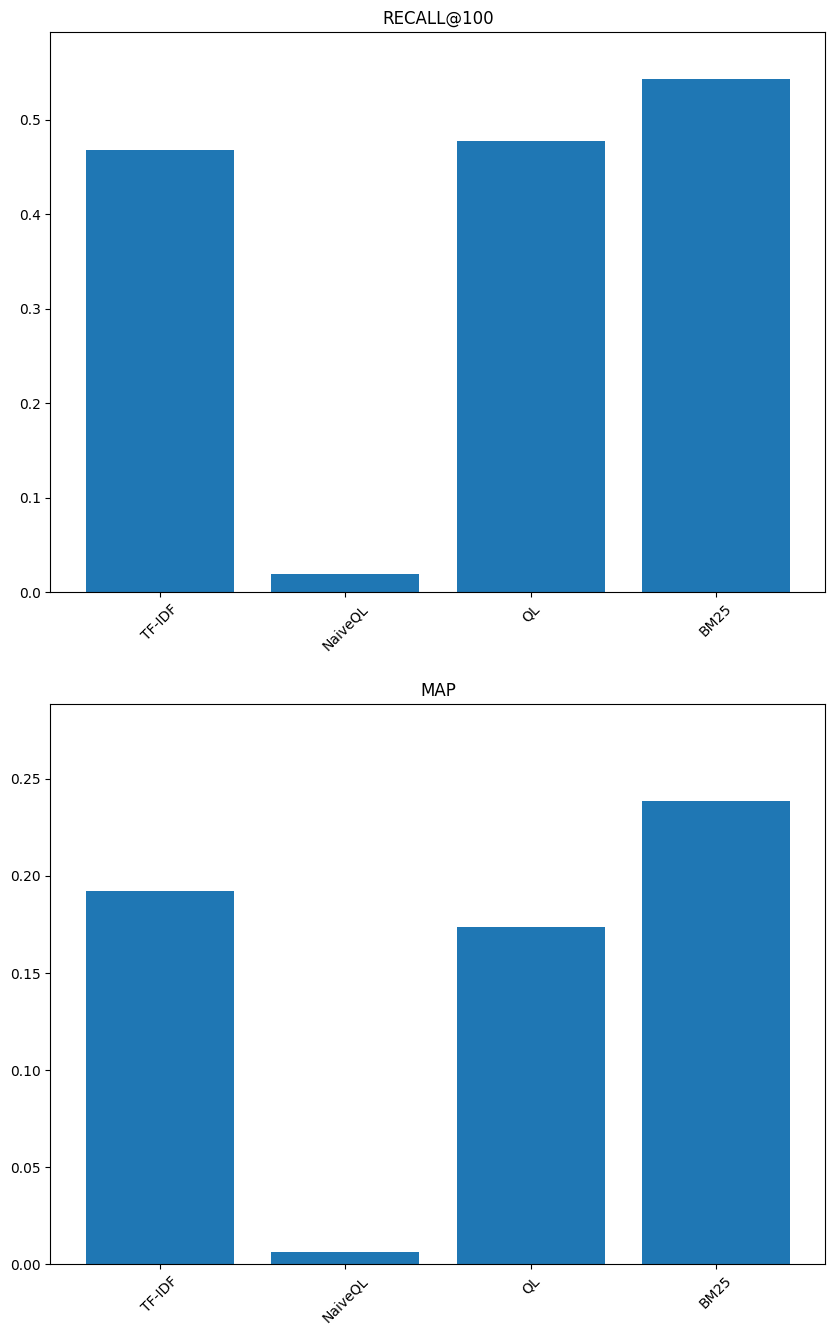

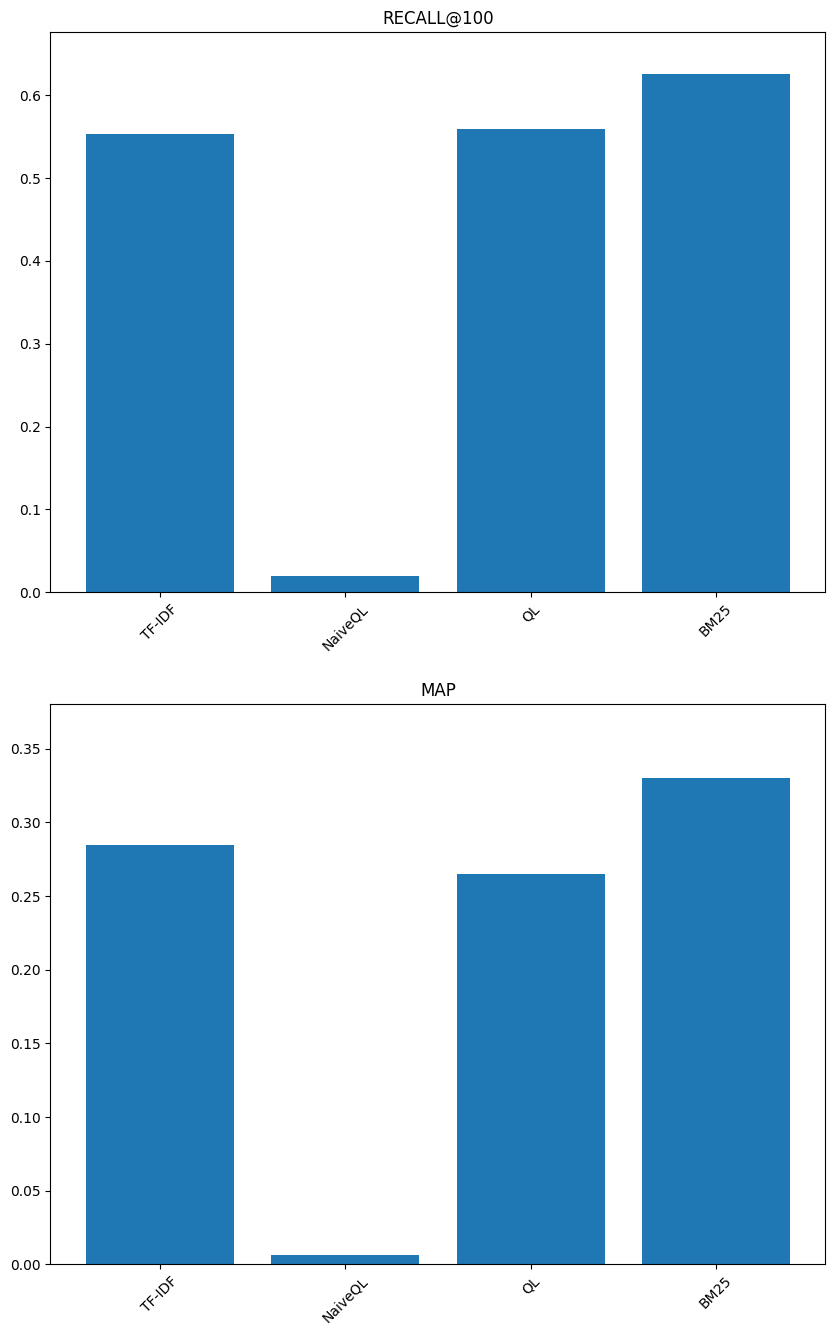

In [39]:
results = {}
index_sets = {1: dh1, 2: dh2}

for index_set, dh in index_sets.items():
    results[index_set] = {}
    print(f"Index: {index_set}")
    for search_fn_name, search_fn in list_of_search_fns:
        print(f"\tEvaluating Search Function: {search_fn_name}")
        results[index_set][search_fn_name] = evaluate_search_fn(
            search_fn_name, search_fn, list_of_metrics, dh, queries, qrels, index_set
        )
        for metric_name, metric_val in results[index_set][search_fn_name].items():
            print(f"\t\tMetric: {metric_name}: {metric_val:0.4f}")
        print()


def plot_metrics(search_fns):

    fig, axes = plt.subplots(nrows=len(list_of_metrics), ncols=1)
    fig.set_figheight(8 * len(list_of_metrics))
    fig.set_figwidth(10)

    for (metric, _), ax in zip(list_of_metrics, axes):
        metrics = []
        labels = []
        for search_fn in search_fns:
            metrics.append(search_fns[search_fn][metric])
            labels.append(search_fn)

        x = np.arange(len(labels))
        rects = ax.bar(x, metrics, label=metric)

        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45)
        ax.set_ylim(ymin=0, ymax=max(metrics) + 0.05)
        ax.set_title(metric)


plot_metrics(results[1])

plot_metrics(results[2])

---
#### 2.2 Summary
Write a summary of what you observe in the results.
Your summary should compare results across the 2 indices and the methods being used. State what you expected to see in the results, followed by either supporting evidence *or* justify why the results did not support your expectations.

**Submission format:**

1. Your runtime evaluation results of the given list of metrics and search functions will be saved in separate files as follows (Make sure the contents of these files are as expected and not damaged due to any errors):

2. You need to submit a concise report in LaTeX summarizing your findings, with a limit of 250 words. Submit your compiled PDF of the report via Canvas before the deadline, including a table of your results.

The analysis evaluates the performance of four Information Retrieval methods (TF-IDF, NaiveQL, QL, BM25) across two indices using RECALL@100 and MAP as evaluation metrics.

BM25 consistently achieves the best performance, with RECALL@100 = 0.5426 and MAP = 0.2383 in Index 1, improving significantly in Index 2 to RECALL@100 = 0.6260 and MAP = 0.3302. This confirms BM25's expected effectiveness due to its probabilistic framework balancing term frequency and document length normalization.

QL performs well, particularly in Index 2 (RECALL@100 = 0.5595, MAP = 0.2648), outperforming TF-IDF in both indices. TF-IDF shows a moderate performance, improving from RECALL@100 = 0.4682 and MAP = 0.1919 in Index 1 to RECALL@100 = 0.5530 and MAP = 0.2848 in Index 2. This suggests that the document distribution and preprocessing steps positively impacted TF-IDF's effectiveness in the second index.

NaiveQL performed the worst across both indices, with minimal improvements between Index 1 (RECALL@100 = 0.0195, MAP = 0.0062) and Index 2 (RECALL@100 = 0.0194, MAP = 0.0063), as expected due to its lack of good term weighting mechanisms.

The results align with expectations: BM25 consistently outperforms other methods, QL follows closely, particularly in Index 2, and TF-IDF improves with changes in preprocessing. NaiveQL's has low performance because of its simplistic approach's limitations. Overall, BM25 proved the most effective, with performance increases in Index 2, supporting the hypothesis that better preprocessing configurations improve retrieval effectiveness.